In [54]:
image_paths = {
    '2018': 'dataset/2018/m_3912112_sw_10_060_20180718.tif',
    '2020': 'dataset/2020/m_3912112_sw_10_060_20200709.tif',
    '2022': 'dataset/2022/m_3912112_sw_10_060_20220714.tif'
}

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import reshape_as_image
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
with rasterio.open(image_paths['2018']) as src:
    image = reshape_as_image(src.read())
    print(f'Image shape: {image.shape}')  # (height, width, bands)

Image shape: (12210, 9610, 4)


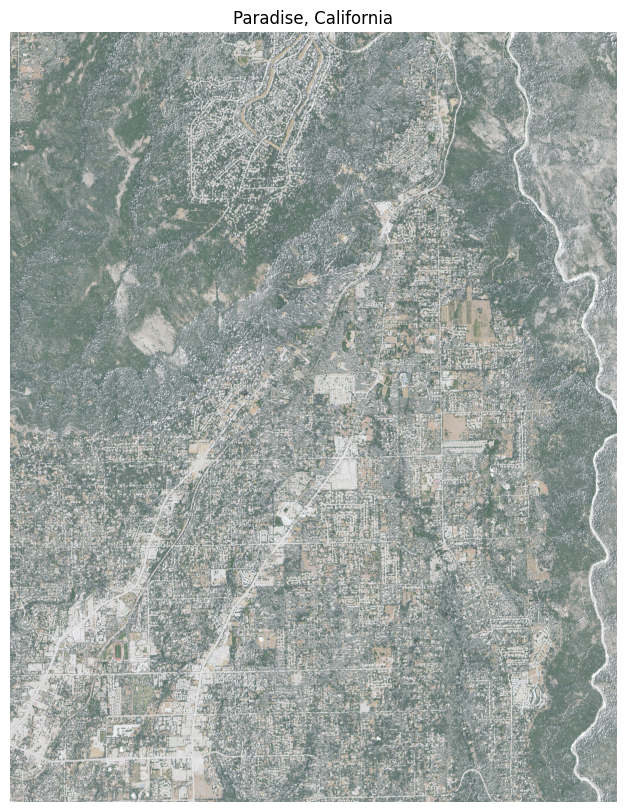

In [10]:
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title('Paradise, California')
plt.axis('off')
plt.show()

In [55]:
import rasterio
from rasterio.plot import show
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def cluster_and_plot_image(image_path, n_clusters=2, colors=['red', 'green'], output_path='clustered_image.tif'):
    """
    Clusters an image using K-means and displays the original and clustered images side by side.
    
    Parameters:
    - image_path: str, path to the input image
    - n_clusters: int, number of clusters for K-means
    - colors: list, colors for each cluster in the output plot
    - output_path: str, path to save the clustered output image
    """
    # Open the image and read the bands
    with rasterio.open(image_path) as src:
        # Read all bands into an array
        image = src.read()  # Shape: (bands, height, width)
        meta = src.meta  # Store metadata for saving later

    # Reshape the image array for KMeans (bands, height, width) -> (height*width, bands)
    pixels = image.reshape(image.shape[0], -1).T  # Shape: (height*width, bands)

    # Apply KMeans clustering
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0).fit(pixels)
    labels = kmeans.labels_

    # Reshape labels to match the original image shape (height, width)
    label_image = labels.reshape((image.shape[1], image.shape[2]))

    # Set up the subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Define a colormap based on the number of clusters and colors provided
    cmap = mcolors.ListedColormap(colors[:n_clusters])

    # Display the original image (assuming it's a 3-band RGB image)
    ax[0].imshow(np.transpose(image[:3], (1, 2, 0)))
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Display the K-means clustered (labeled) image
    im = ax[1].imshow(label_image, cmap=cmap)  # Colormap for distinct classes
    ax[1].set_title("K-Means Clustered Image")
    ax[1].axis("off")

    # Add color bar to the clustered image
    cbar = plt.colorbar(im, ax=ax[1], ticks=range(n_clusters))
    cbar.set_label('Cluster ID')
    cbar.set_ticklabels([f'Cluster {i+1}' for i in range(n_clusters)])

    plt.show()

    # Save the labeled image as a new raster
    with rasterio.open(f'labels/{output_path}', 'w', **meta) as dst:
        dst.write(label_image.astype(rasterio.uint8), 1)  # Save as single-band labeled raster

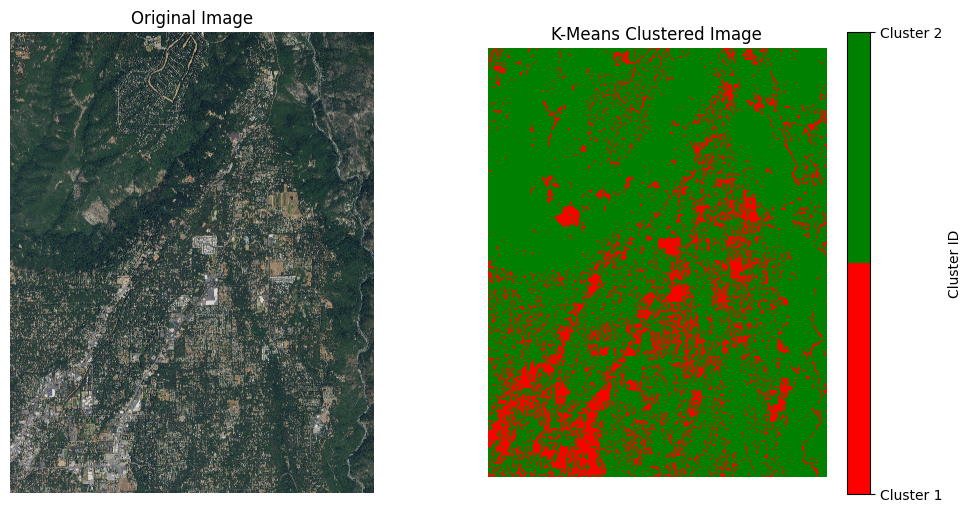

In [17]:

cluster_and_plot_image(image_paths['2018'], n_clusters=2, colors=['red', 'green'], output_path='saved_labelled_2018.tif')

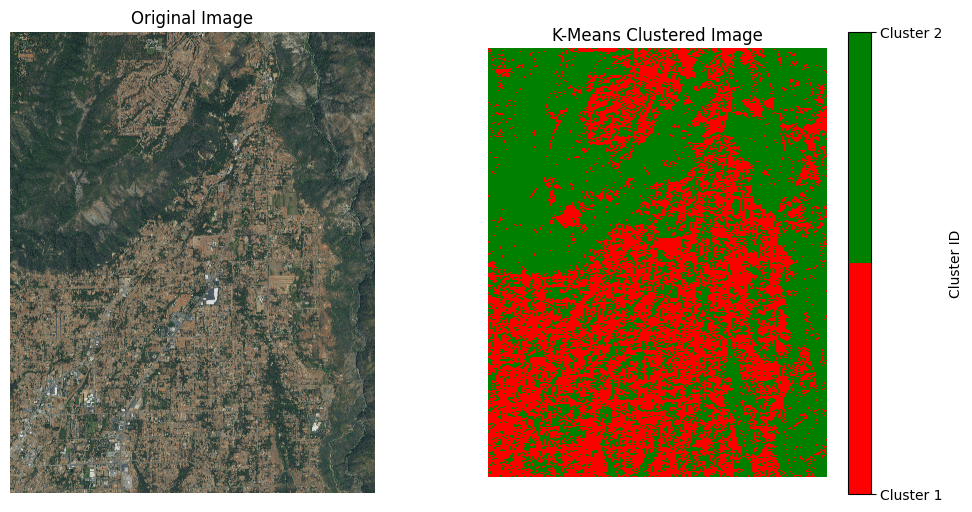

In [22]:
cluster_and_plot_image(image_paths['2020'], n_clusters=2, colors=['red', 'green'], output_path='saved_labelled_2020.tif')

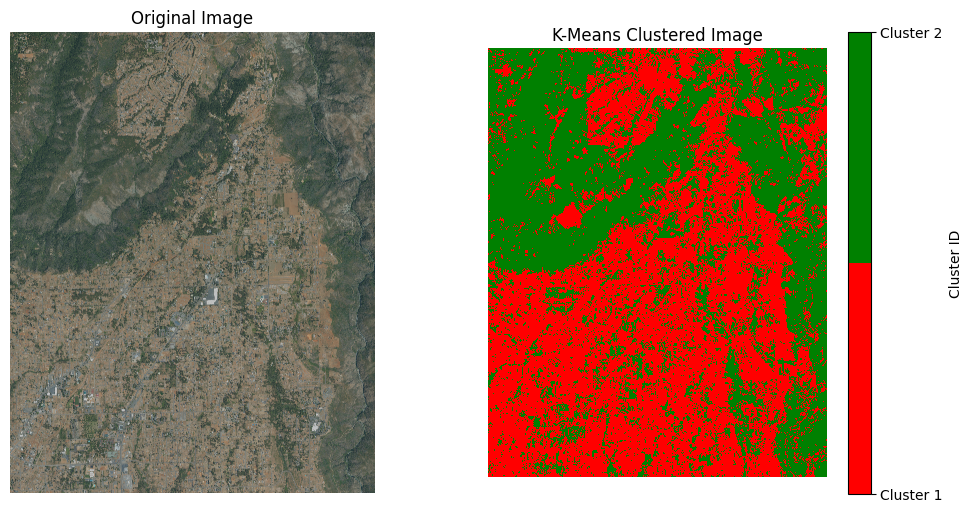

In [21]:
cluster_and_plot_image(image_paths['2022'], n_clusters=2, colors=['red', 'green'], output_path='saved_labelled_2022.tif')

In [20]:
import rasterio
import numpy as np

def inspect_labeled_image(label_path):
    """
    Inspects a labeled raster image, displaying basic information and unique values.
    
    Parameters:
    - label_path: str, path to the labeled raster image
    """
    with rasterio.open(label_path) as src:
        # Read the first (and only) band containing the labels
        label_image = src.read(1)
        
        # Print basic metadata
        print("Image Width:", src.width)
        print("Image Height:", src.height)
        print("Data Type:", label_image.dtype)
        
        # Display unique label values
        unique_labels = np.unique(label_image)
        print("Unique Labels (Clusters):", unique_labels)
        
        # Display a small sample of the data
        print("Sample Data (first 5x5 pixels):")
        print(label_image[:5, :5])

# Example usage
inspect_labeled_image('saved_labelled_2018.tif')

Image Width: 9610
Image Height: 12210
Data Type: uint8
Unique Labels (Clusters): [0 1]
Sample Data (first 5x5 pixels):
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


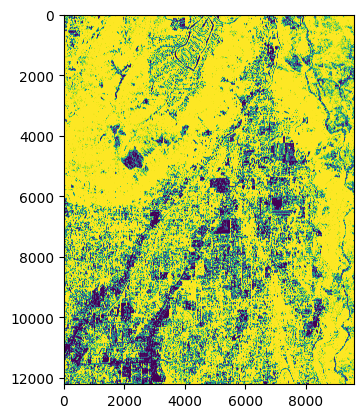

In [ ]:
img = 'saved_labelled_2018.tif'

with rasterio.open(img) as src:
    img = src.read(1)
    
    img = np.array(img, dtype=np.uint8)
    
    # plot the image
    plt.imshow(img)
    plt.show()

In [26]:
def plot_label_image(label_image):
    with rasterio.open(label_image) as src:
        img = src.read(1)
        
        img = np.array(img, dtype=np.uint8)
        
        # plot the image
        plt.imshow(img)
        plt.show()

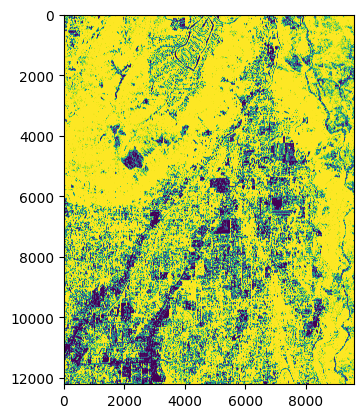

In [27]:
plot_label_image('saved_labelled_2018.tif')

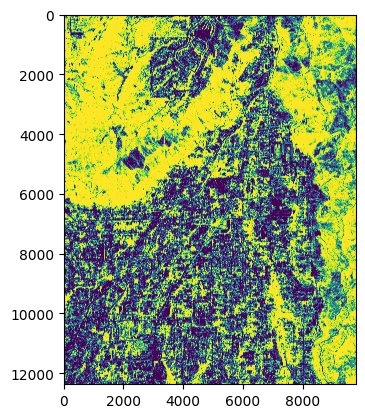

In [28]:
plot_label_image('saved_labelled_2020.tif')

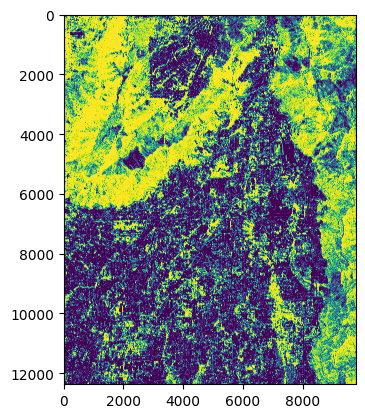

In [29]:
plot_label_image('saved_labelled_2022.tif')

In [52]:

def calculate_and_plot_forest_area_by_year(image_paths, years, save_path=None):
    """
    Reads multiple labeled images, calculates forest and non-forest areas for each year,
    and creates a bar plot showing the areas for each year as individual pairs.
    
    Parameters:
    - image_paths: list of str, paths to the labeled raster images
    - years: list of int, years corresponding to each image path
    """
    areas = []  # To store forest and non-forest areas for each year
    
    for image_path in image_paths:
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            areas.append((0, 0))  # Add 0s if file is missing
            continue
        
        with rasterio.open(image_path) as src:
            label_image = src.read(1)  # Read the first (and only) band
            
            # Calculate the area by counting pixels in each category
            forest_area = np.sum(label_image == 1)  # Assuming 1 represents forest
            non_forest_area = np.sum(label_image == 0)  # Assuming 0 represents non-forest
            
            # Append results for each year
            areas.append((forest_area, non_forest_area))
            
            # Print individual image areas (optional)
            print(f"Image: {image_path}")
            print(f"Forest Area: {forest_area}")
            print(f"Non-Forest Area: {non_forest_area}\n")
    
    # Separate forest and non-forest areas for plotting
    forest_areas = [area[0] for area in areas]
    non_forest_areas = [area[1] for area in areas]

    # Plot forest and non-forest areas for each year as individual pairs
    index = np.arange(len(years) * 2)  # One bar per forest and non-forest pair
    bar_labels = [f'{year} Forest' if i % 2 == 0 else f'{year} Non-Forest' for i, year in enumerate(np.repeat(years, 2))]
    
    plt.figure(figsize=(10, 6))
    plt.bar(index[::2], forest_areas, label='Forest', color='green', width=0.4, align='center')
    plt.bar(index[1::2], non_forest_areas, label='Non-Forest', color='brown', width=0.4, align='center')
    
    plt.xlabel('Year and Category')
    plt.ylabel('Area (in pixels)')
    plt.title('Forest and Non-Forest Areas by Year')
    plt.xticks(index, bar_labels, rotation=45, ha='right')
    plt.legend(['Forest', 'Non-Forest'])
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
        print(f"Plot saved to {save_path}")
    
    plt.show()

Image: labels/saved_labelled_2018.tif
Forest Area: 92133277
Non-Forest Area: 25204823

Image: labels/saved_labelled_2020.tif
Forest Area: 69321235
Non-Forest Area: 51533665

Image: labels/saved_labelled_2022.tif
Forest Area: 55889818
Non-Forest Area: 64965082

Plot saved to insight.png


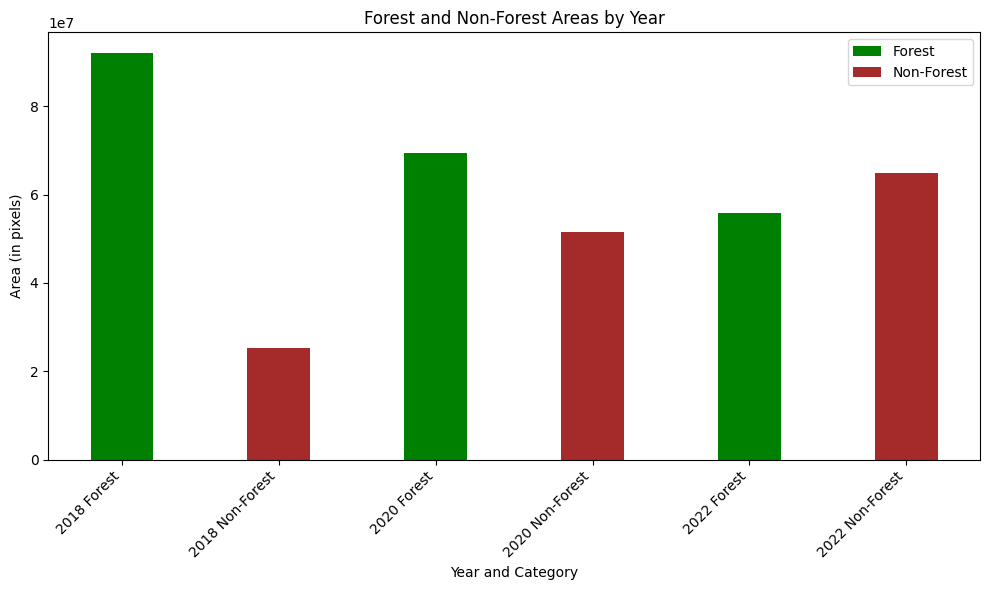

In [56]:
years = [2018, 2020, 2022]
label_paths = [f'labels/saved_labelled_{x}.tif' for x in years]
plt = calculate_and_plot_forest_area_by_year(label_paths, years, save_path='insight.png')